# <span style="color:skyblue;"> Mini-Bert pretrained model 만들기 </span>

데이터 코퍼스는 한국 나무위키 코퍼스 400만 개에서 Random Sampling

각 시행에 대해서 시드는 고정할 것  
GLOBAL_SEED : [20, 21, 22, 25, 28, 29, 6]

### <span style="color:skyblue;"> Result </span>


| 시행 | Model Size | Epochs | Corpus Size  | Average NSP Loss | Average MLM Loss | Average NSP Acc | Average MLM Acc |
|----------|----------|----------|----------|----------|----------|----------|----------|
| BaseLine | 1.5M | 10 | 128K | ~0.5 | ~0.75 | ~0.65 | ~0.15 |
| 시행 2 | 4.5M | 10 | 128K | 0.49(&plusmn;0.03) | 0.54(&plusmn;0.05)) | 0.80(&plusmn;0.03) | 0.24(&plusmn;0.04) |
| 시행 3-A | 4.5M | 15 | 192K | 0.48(&plusmn;0.02) | 0.49(&plusmn;0.04)) | 0.81(&plusmn;0.03) | 0.28(&plusmn;0.04) |
| 시행 3-B | 6.0M | 15 | 128K | <span style="color:skyblue;"> 0.47(&plusmn;0.03) </span> | <span style="color:skyblue;"> 0.46(&plusmn;0.04)) </span> | <span style="color:skyblue;"> 0.83(&plusmn;0.03)  </span> | <span style="color:skyblue;"> 0.30(&plusmn;0.05) </span>|

```* MLM loss는 최적화 과정에서는 NSP에 대해서 20배 민감하도록 설정하였으나, 시각화 시에는 동일한 스케일로 비교되도록 조정하였음```

- 데이터 코퍼스를 128K에서 192K로 약 1.5배 증가시켰을 경우 Epoch 10 기준 성능이 거의 동일함
- 그에 비해 데이터 크기는 유지하고 모델 용량을 6M 까지 확장한 경우에는 소폭의 성능 향상이 있었음
- 경량 모델을 제작하는 데 있어 베이스라인 1.5M 모델보다는 4.5M 수준까지 확장하는 것이 성능 개선에서 최적으로 보임
___

#### 최초 시행: 언더피팅 가능성 &rightarrow; epoch을 늘리거나, 모델을 키우거나인데 후자를 택해보자
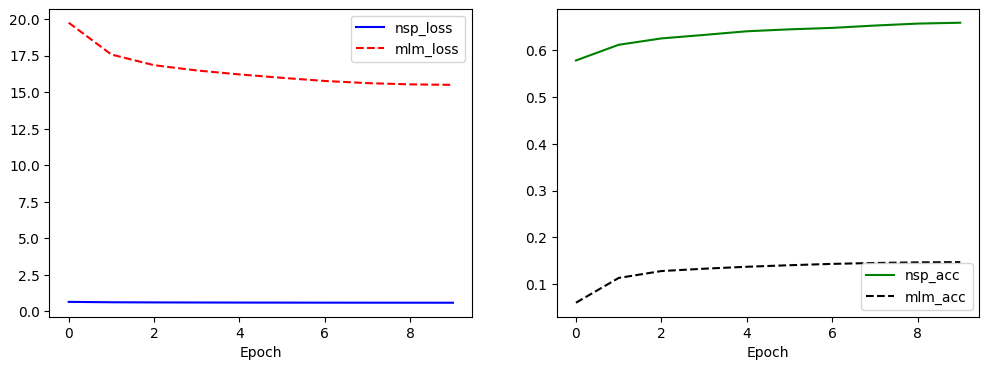
___
## 시행 2.
### <span style="color:skyblue;"> Q. 데이터 갖고 오기를 128000개를 활용했는데, 랜덤으로 가져오도록 해서 여러 시행을 하면 학습 분포가 어떻게 될까? </span>

A. NSP가 깨지지 않도록 한 채로 400만 개의 데이터에서 랜덤으로 128000개를 가져온 경우, 시행 7회 기준 데이터 분포가 매우 다르고 따라서 학습 커브 양상이 조금씩은 다르다.

Epoch 10 기준 최적점에 도달하지는 않은 듯? loss와 acc 기준으로는 각 run 당 epoch 15까지 학습을 진행시켜도 좋을 듯 하다

생각해보니까 validation set 구성을 안했다... 랜덤 셔플이라 데이터 누출 안 시키면서 intersection(train, test) = vacuum 이 되려면 쉽지 않겠다 일단 보류

#### Model Hyperparameters: Total Parameters ~ 4.5M. 각 run 당 소요 시간 ~ 20 min, total ~ 140 min.

    {'d_model': 256,
     'n_head': 4,
     'd_head': 64,
     'dropout': 0.1,
     'd_ff': 1024,
     'layernorm_epsilon': 0.001,
     'n_layer': 3,
     'n_seq': 128,
     'n_vocab': 8007,
     'i_pad': 0}

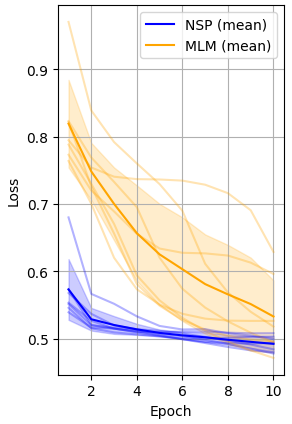
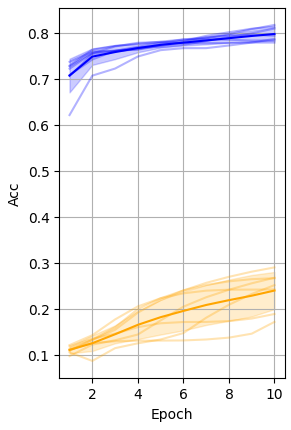

분기를 만들어서 서로 다른 측면을 관찰해보자.
___
## 시행 3-A.
### <span style="color:skyblue;"> Q. 인풋 데이터를 기존의 128000개에서 더 늘리는 경우, 동일 하이퍼파라미터에서 learning curve의 분포는 어떻게 바뀔 것인가? </span>

변화: 인풋 데이터 192000으로 증가, epoch 15까지 진행

직관적인 기대: 데이터가 늘어나니 loss는 증가하고 acc는 감소할 것

#### Model Hyperparameters: Total Parameters ~ 4.5M. 각 run 당 소요 시간 ~ 45 min, total ~ 300 min

    {'d_model': 256,
     'n_head': 4,
     'd_head': 64,
     'dropout': 0.1,
     'd_ff': 1024,
     'layernorm_epsilon': 0.001,
     'n_layer': 3,
     'n_seq': 128,
     'n_vocab': 8007,
     'i_pad': 0}

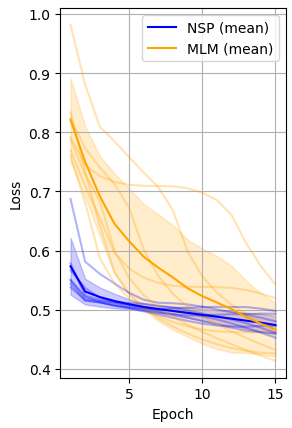
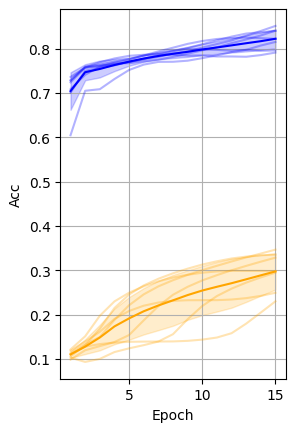
___
## 시행 3-B.
### <span style="color:skyblue;"> Q. 시행 2와 같은 하이퍼파라미터 기준, 모델을 약 6M까지 확장한 경우 learning curve의 분포는 어떻게 바뀔 것인가? </span>

변화: layer num 3 &rightarrow; 5, epoch 15까지 진행

직관적인 기대: 모델이 커지니 더 빠르게 피쳐를 잡고 loss가 시행 2에 비해 감소하고, acc는 증가할 것으로 예상

#### Model Hyperparameters: Total Parameters ~ 6.0M. 각 run 당 소요 시간 ~ 45 min, total ~ 300 min.

    {'d_model': 256,
     'n_head': 4,
     'd_head': 64,
     'dropout': 0.1,
     'd_ff': 1024,
     'layernorm_epsilon': 0.001,
     'n_layer': 5,
     'n_seq': 128,
     'n_vocab': 8007,
     'i_pad': 0}

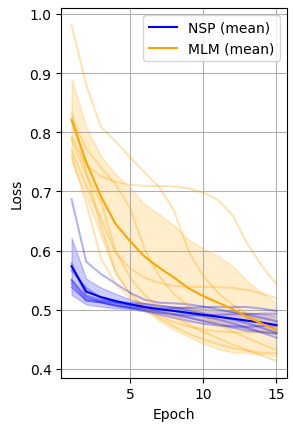
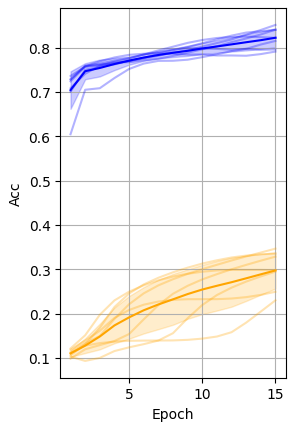

## 중간 회고
1. 시드를 다르게 multiple run을 돌리는 경우에 있어 memmap을 덮어씌우지 못 하는 이슈 발생. 이는 아무래도 memmap 파일을 파이썬에서 실행하고 있기 때문에 프로세스를 종료하지 못 한 채로 덮어씌우려는 시도가 에러가 난 것으로, 메모리가 32GB로 여유로운 편이라서 그냥 np.array로 바꿔서 사용했음 

2. 모델을 4.5M 사이즈까지 키운 상태에서도 loss와 acc의 경향이 monotone이지만 loss가 충분히 감소했다고는 생각하지 않기에, i) 약 6M 까지 키워서 훈련 데이터에 대해 충분히 적합할 수 있도록 만들어보거나, ii) epoch을 두 세 스텝 정도 더 늘리는 것도 고려해봐도 될 듯?

3. 텍스트 데이터는 차원이 정말 방대해서, 인구조사와 다르게 뭔가 12만개의 데이터가 전체를 대표할 거라는 보장이 딱히 안들었음. 그래서 1.5배 코퍼스를 늘려서 192000개에 대해서 실험했을 때 accuracy가 어떻게 되는 지 봐도 좋을 것 같고, 뭐 가능하다면 validation set을 구성해서 검증단계까지 구성해보는 것도 가능할듯?

4. 데이터 코퍼스를 늘리는 것 보다 모델 용량을 키우는 것이 더 성능적인 측면에서 살짝 좋았음

### 1. SentencePiece 토크나이저를 활용하여 코퍼스 처리

데이터 토큰 랜덤 마스킹, 길이 맞추기, 데이터 저장 및 로드

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K

import math
import numpy as np
import random
import json
import copy

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 2025
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

#### SentencePiece 모델 형성

In [3]:
corpus_file = "C:/datasets_temp/kowiki.txt"

In [ ]:
prefix = "C:/datasets_temp/ko_8000"
vocab_size = 8000
spm.SentencePieceTrainer.train(input=corpus_file,
                               model_prefix=prefix, 
                               vocab_size=vocab_size + 7,
                               model_type='bpe',
                               max_sentence_length=999999,
                               pad_id=0, 
                               pad_piece="[PAD]", 
                               unk_id=1, 
                               unk_piece="[UNK]", 
                               bos_id=2,
                               bos_piece="[BOS]",
                               eos_id=3, eos_piece="[EOS]",
                               user_defined_symbols=["[SEP]","[CLS]","[MASK]"])

In [4]:
vocab = spm.SentencePieceProcessor()

In [5]:
vocab.load("C:/datasets_temp/ko_8000.model")

True

In [6]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    : param tokens: tokens
    : param mask_cnt: mask 개수 (전체 tokens의 n%)
    : param vocab_list: vocab list (random token 용)
    
    : return tokens: mask된 tokens
    : return mask_idx: mask된 token의 index
    : return mask_label: mask된 token의 원래 값
    """
    cand_idx = []
    # cls, sep 등이 들어간 토큰화된 센텐스라고 가정
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if len(cand_idx) > 0 and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    
    random.shuffle(cand_idx)
    
    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 mask_cnt를 넘으면 중지
          break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 n%를 넘으면 skip
          continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
        
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

In [7]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [8]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []  # line 단위 tokens
    current_length = 0
    for i in range(len(doc)):  # doc 전체를 loop
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
                
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])
    
            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

    
            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)
    
            current_chunk = []
            current_length = 0
    return instances

In [9]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r", encoding='utf-8') as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r", encoding='utf-8') as in_f:
        with open(out_file, "w", encoding='utf-8') as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if len(doc) > 0:
                        save_pretrain_instances(out_f, doc)
                        doc=[]
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if len(pieces) > 0:
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc=[]

In [62]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드 (랜덤 샘플링 포함)
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """

    # 파일에서 모든 데이터를 로드
    with open(filename, "r", encoding='utf-8') as f:
        lines = f.readlines()

    # 랜덤 샘플링 적용
    if count is not None:
        lines = random.sample(lines, min(count, len(lines)))  # 데이터 샘플링

    total = len(lines)

    # np.zeros()를 사용하여 메모리에 저장 (memmap 대신)
    enc_tokens = np.zeros((total, n_seq), dtype=int)
    segments = np.zeros((total, n_seq), dtype=int)
    labels_nsp = np.zeros((total,), dtype=int)
    labels_mlm = np.zeros((total, n_seq), dtype=int)

    # 샘플링된 lines 리스트를 직접 사용
    for i, line in enumerate(tqdm(lines, total=total)):
        data = json.loads(line)

        # Encoder token
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
        enc_token += [0] * (n_seq - len(enc_token))

        # Segment
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))

        # NSP label
        label_nsp = data["is_next"]

        # MLM label
        mask_idx = np.array(data["mask_idx"], dtype=int)
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=int)
        label_mlm = np.full(n_seq, dtype=int, fill_value=0)
        label_mlm[mask_idx] = mask_label

        # 길이 검증
        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        # NumPy 배열에 데이터 저장
        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [12]:
pretrain_json_path = 'C:/datasets_temp/bert_pre_train.json'

In [48]:
make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [125]:
# 인자: Vocab, json 파일, 시퀀스 길이, 데이터 개수

## 여기서 파일 커서 다른 곳으로 옮겼음 

pre_train_inputs, pre_train_labels = load_pre_train_data(
    vocab,
    pretrain_json_path,
    128,
    count=192000)

  0%|          | 0/192000 [00:00<?, ?it/s]

### 2. BERT 구현

In [14]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

In [15]:
# experimental_relax_shapes=True  
# 옵션은 입력 텐서의 크기가 달라도 그래프를 재사용 가능하게 함
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

In [16]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

In [17]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r', encoding='utf-8') as f:
            config = json.loads(f.read())
            return Config(config)

In [18]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [19]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [20]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [22]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [23]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [24]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [25]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [26]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

#### 2-1. 최적화 도구 정의

In [27]:
def lm_loss(y_true, y_pred, rate=20):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * rate  # mlm을 더 잘 학습하도록 rate배 증가 시킴

In [28]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [29]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

#### 2-2. 시각화 도구 정의

In [106]:
def plot_learning_curves(all_nsp_loss,
                         all_mlm_loss,
                         all_nsp_acc,
                         all_mlm_acc):
    """
    여러 번의 학습 run에서 수집된 Train/Val Loss를
    평균 곡선과 표준편차 음영으로 플롯
    """
    n_runs = len(all_nsp_loss)
    epochs = len(all_nsp_loss[0])
    epoch_range = np.arange(1, epochs+1)
    
    all_mlm_loss = np.array(all_mlm_loss) / 20
    
    mean_nsp_loss = np.mean(all_nsp_loss, axis=0)
    std_nsp_loss = np.std(all_nsp_loss, axis=0)
    
    mean_mlm_loss = np.mean(all_mlm_loss, axis=0)
    std_mlm_loss = np.std(all_mlm_loss, axis=0)
    
    mean_nsp_acc = np.mean(all_nsp_acc, axis=0)
    std_nsp_acc = np.std(all_nsp_acc, axis=0)
    
    mean_mlm_acc = np.mean(all_mlm_acc, axis=0)
    std_mlm_acc = np.std(all_mlm_acc, axis=0)
    
    plt.figure()
    
    # 개별 run의 곡선 (투명하게)
    plt.subplot(1,2,1)
    for i in range(n_runs):
        plt.plot(epoch_range, all_nsp_loss[i], color='blue', alpha=0.3)
        plt.plot(epoch_range, all_mlm_loss[i], color='orange', alpha=0.3)
    
    # 평균 곡선
    plt.plot(epoch_range, mean_nsp_loss, color='blue', label='NSP (mean)', linewidth=1.5)
    plt.plot(epoch_range, mean_mlm_loss, color='orange', label='MLM (mean)', linewidth=1.5)
    
    # 표준편차 음영
    plt.fill_between(epoch_range, mean_nsp_loss-std_nsp_loss, mean_nsp_loss+std_nsp_loss, color='blue', alpha=0.2)
    plt.fill_between(epoch_range, mean_mlm_loss-std_mlm_loss, mean_mlm_loss+std_mlm_loss, color='orange', alpha=0.2)
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.subplot(1,2,2)
    for i in range(n_runs):
        plt.plot(epoch_range, all_nsp_acc[i], color='blue', alpha=0.3)
        plt.plot(epoch_range, all_mlm_acc[i], color='orange', alpha=0.3)
    
    # 평균 곡선
    plt.plot(epoch_range, mean_nsp_acc, color='blue', label='NSP Acc (mean)', linewidth=1.5)
    plt.plot(epoch_range, mean_mlm_acc, color='orange', label='MLM Acc (mean)', linewidth=1.5)
    
    # 표준편차 음영
    plt.fill_between(epoch_range, mean_nsp_acc-std_nsp_acc, mean_nsp_acc+std_nsp_acc, color='blue', alpha=0.2)
    plt.fill_between(epoch_range, mean_mlm_acc-std_mlm_acc, mean_mlm_acc+std_mlm_acc, color='orange', alpha=0.2)
    
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.grid(True)
    plt.show()

### 3. 모델 반복시행

In [126]:
config = Config({"d_model": 256,
                 "n_head": 4,
                 "d_head": 64,
                 "dropout": 0.1,
                 "d_ff": 1024,
                 "layernorm_epsilon": 0.001,
                 "n_layer": 3,
                 "n_seq": 128,
                 "n_vocab": 0,
                 "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 128,
 'n_vocab': 8007,
 'i_pad': 0}

In [127]:
epochs = 15
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint("bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)

In [ ]:
### 지난 주 로또번호
seed_list = [20, 21, 22, 25, 28, 29, 6]

all_nsp_loss = []
all_mlm_loss = []
all_nsp_acc = []
all_mlm_acc = []

for i, seed in enumerate(seed_list):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    print('Current Seed:', seed)
    
    pre_train_model = build_model_pre_train(config)
    pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})
    
    history = pre_train_model.fit(pre_train_inputs, pre_train_labels,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  verbose=1)
    
    all_nsp_loss.append(history.history['nsp_loss'])
    all_mlm_loss.append(history.history['mlm_loss'])
    all_nsp_acc.append(history.history['nsp_acc'])
    all_mlm_acc.append(history.history['mlm_lm_acc'])

3000/3000 [==============================] - 202s 67ms/step - loss: 12.5571 - nsp_loss: 0.5084 - mlm_loss: 12.0488 - nsp_acc: 0.7721 - mlm_lm_acc: 0.1839
Epoch 13/15
3000/3000 [==============================] - 231s 77ms/step - loss: 12.0259 - nsp_loss: 0.5069 - mlm_loss: 11.5189 - nsp_acc: 0.7730 - mlm_lm_acc: 0.2027
Epoch 14/15
 784/3000 [======>.......................] - ETA: 2:52 - loss: 11.6624 - nsp_loss: 0.5053 - mlm_loss: 11.1570 - nsp_acc: 0.7791 - mlm_lm_acc: 0.2176

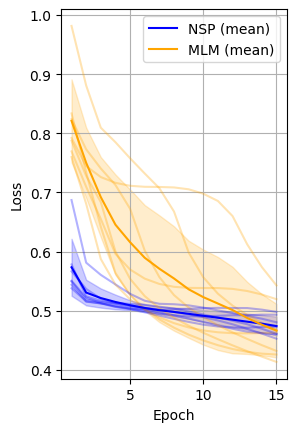

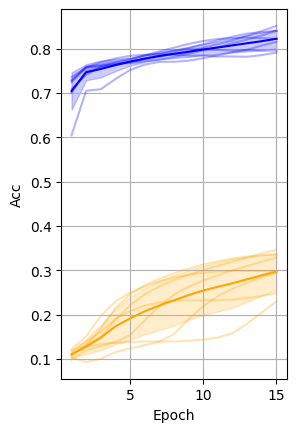

In [122]:
plot_learning_curves(all_nsp_loss,
                         all_mlm_loss,
                         all_nsp_acc,
                         all_mlm_acc)

In [124]:
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 256),        4452864     ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                           

### (Deprecated) 모델 Config / 시행

In [32]:
config = Config({"d_model": 128,
                 "n_head": 4,
                 "d_head": 32,
                 "dropout": 0.1,
                 "d_ff": 512,
                 "layernorm_epsilon": 0.001,
                 "n_layer": 3,
                 "n_seq": 128,
                 "n_vocab": 0,
                 "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 128,
 'n_head': 4,
 'd_head': 32,
 'dropout': 0.1,
 'd_ff': 512,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 128,
 'n_vocab': 8007,
 'i_pad': 0}

In [33]:
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 128),        1636608     ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                            

In [69]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

In [70]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint("bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels,
                              epochs=epochs,
                              batch_size=batch_size,
                              callbacks=save_weights)


KeyboardInterrupt



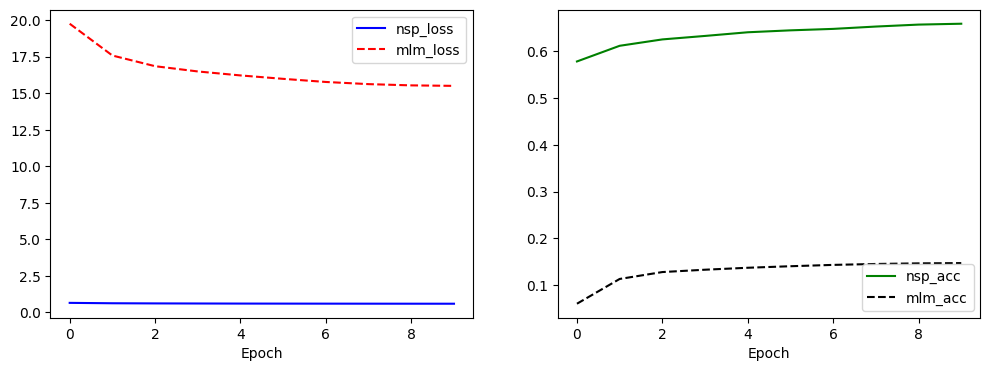

In [36]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()